In [1]:
import os
import sys
import importlib
import pickle

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
project_path = 'C:\\Users\\danny\\Documents_Local\\Caltech_2023-2024\\CS101'

def join_path(relative_path: str) -> str:
    return os.path.join(project_path, relative_path)

def pickle_load(relative_path: str):  # -> pickled_file_contents
    return pickle.load(open(join_path(relative_path), 'rb'))

def pickle_save(obj: object, relative_path: str) -> None:
    pickle.dump(obj, open(join_path(relative_path), 'wb'))

In [3]:
sys.path.append(join_path('EMIT-ECOSTRESS\\modules'))
import data.Datasets
import models.Feedforward
import models.Attention
import utils.train

In [4]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

In [12]:
# Make datasets and dataloaders

# setup

importlib.reload(data.Datasets)

omit_components = 244 - 8

batch_size = 256

base_data_path = (join_path('Data\\Split_Data_2'))

train_splits = ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18']
val_splits = ['01', '05', '09', '13', '17']
test_splits = ['03', '07', '11', '15', '19']


# load data

# emit
emit_train_list = []
for split in train_splits:
    emit_train_list.append(
        pickle_load(
            os.path.join(
                base_data_path, f'Full_PCA\\reflectance_{split}_pca244.pkl'
            )
            # os.path.join(base_data_path, f'KPCA\\Cosine\\reflectance_{split}.pkl')
        )
    )
emit_train = np.concatenate(emit_train_list, axis=0)

emit_val_list = []
for split in val_splits:
    emit_val_list.append(
        pickle_load(
            os.path.join(
                base_data_path, f'Full_PCA\\reflectance_{split}_pca244.pkl'
            )
            # os.path.join(base_data_path, f'KPCA\\Cosine\\reflectance_{split}.pkl')
        )
    )
emit_val = np.concatenate(emit_val_list, axis=0)

# ecostress
eco_train_list = []
for split in train_splits:
    eco_train_list.append(
        pickle_load(
            os.path.join(
                base_data_path, f'List_Data\\temp_day_{split}_list.pkl'
            )
        )
    )
eco_train = np.concatenate(eco_train_list, axis=0)

eco_val_list = []
for split in val_splits:
    eco_val_list.append(
        pickle_load(
            os.path.join(
                base_data_path, f'List_Data\\temp_day_{split}_list.pkl'
            )
        )
    )
eco_val = np.concatenate(eco_val_list, axis=0)

# elevation
elev_train_list = []
for split in train_splits:
    elev_train_list.append(
        pickle_load(
            os.path.join(
                base_data_path, f'List_Data\\elevation_{split}_list.pkl'
            )
        )
    )
elev_train = np.concatenate(elev_train_list, axis=0)

elev_val_list = []
for split in val_splits:
    elev_val_list.append(
        pickle_load(
            os.path.join(
                base_data_path, f'List_Data\\elevation_{split}_list.pkl'
            )
        )
    )
elev_val = np.concatenate(elev_val_list, axis=0)


# create datasets and dataloaders

train_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    device=device,
)

val_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    device=device,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, drop_last=True
)

In [14]:
# Make model, optimizer, and loss function
importlib.reload(models.Feedforward)
importlib.reload(models.Attention)

n_epochs = 100

model = models.Feedforward.ToyModel(
    input_dim=train_dataset.input_dim
)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='sum')

model

ToyModel(
  (linear1): Linear(in_features=9, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=8, bias=True)
  (linear_output): Linear(in_features=8, out_features=1, bias=True)
  (layernorm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (layernorm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (layernorm3): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
)

In [15]:
importlib.reload(utils.train)
train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=1,
    # preexisting_losses=[train_loss, val_loss],
    device=device,
)

Epoch 000	 Train Loss: 1.5293	 Val Loss: 1.5161 	 Avg Error: 14.595	LR: 0.0001	Time: 1.8e+01
Epoch 001	 Train Loss: 0.97425	 Val Loss: 0.998 	 Avg Error: 11.841	LR: 0.0001	Time: 1.9e+01
Epoch 002	 Train Loss: 0.99604	 Val Loss: 0.98805 	 Avg Error: 11.782	LR: 0.0001	Time: 1.9e+01
Epoch 003	 Train Loss: 0.98273	 Val Loss: 0.97448 	 Avg Error: 11.701	LR: 0.0001	Time: 1.9e+01
Epoch 004	 Train Loss: 0.96014	 Val Loss: 0.96329 	 Avg Error: 11.633	LR: 0.0001	Time: 1.9e+01
Epoch 005	 Train Loss: 0.92804	 Val Loss: 0.99841 	 Avg Error: 11.844	LR: 0.0001	Time: 1.9e+01
Epoch 006	 Train Loss: 0.86946	 Val Loss: 0.92184 	 Avg Error: 11.38	LR: 0.0001	Time: 1.9e+01
Epoch 007	 Train Loss: 0.79517	 Val Loss: 0.88691 	 Avg Error: 11.163	LR: 0.0001	Time: 2e+01
Epoch 008	 Train Loss: 0.5566	 Val Loss: 0.75494 	 Avg Error: 10.299	LR: 0.0001	Time: 1.9e+01
Epoch 009	 Train Loss: 0.46289	 Val Loss: 0.67514 	 Avg Error: 9.7392	LR: 0.0001	Time: 2.1e+01
Epoch 010	 Train Loss: 0.40517	 Val Loss: 0.66568 	 Avg Er

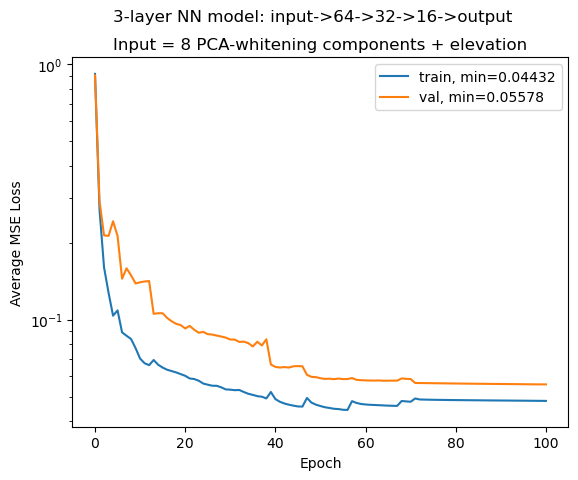

In [ ]:
fig, ax = plt.subplots()
fig.suptitle('3-layer NN model: input->64->32->16->output')
ax.set_title('Input = 8 PCA-whitening components + elevation')
ax.semilogy(
    np.arange(len(train_loss)),
    train_loss,
    label=f'train, min={min(train_loss):.4}',
)
ax.semilogy(
    np.arange(len(val_loss)), val_loss, label=f'val, min={min(val_loss):.4}'
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)